In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../Data/df_final.csv',index_col="time")

In [4]:
# Our dependant variables are two variables (generation solar, generation wind onshore). 
# But here, we are just predicting "generation solar"
X = df.drop(columns=['generation solar','generation wind onshore'])
y_solar = df['generation solar']

In [13]:
# Split the data into train and test based on specific time '2017-12-31 23:00:00+00:00'
def split_by_date(X,train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    
    return X_train, X_test

train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X,train_end_date)
y_solar_train, y_solar_test = split_by_date(y_solar, train_end_date)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
np.linspace(4,8,3)

array([4., 6., 8.])

In [34]:
xgb_reg = xgb.XGBRegressor(eval_metric = "rmse")
param_grid = {"max_depth": [4,5,6],
              "n_estimators" : [50, 100, 150],
              "learning_rate": [0.01, 0.015]
    
}
search = GridSearchCV(xgb_reg, param_grid, cv=5).fit(X_train_scaled, y_solar_train)
print("The best hyperparameters are ",search.best_params_)


The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 150}


In [35]:
xgb_reg=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                        eval_metric = "rmse")


In [36]:
xgb_reg.fit(X_train_scaled, y_solar_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
y_solar_predict = xgb_reg.predict(X_test_scaled)

In [38]:
mse = mean_squared_error(y_solar_test, y_solar_predict)
print("Mean Squared Error:", mse)

Mean Squared Error: 71223.92508037455


## Feature Importance Anaylsis 

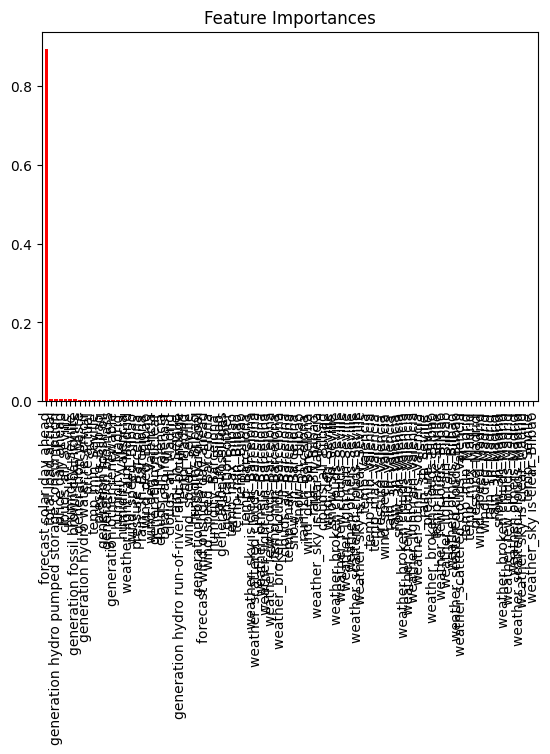

In [39]:
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()